In [65]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
sns.set()

Wczytuję dane i wykonuję modyfikację, takie jak podczas tworzenia regresji, aby uniknąć rozbierzności w danych.

In [66]:
df_waw_text = pd.read_excel(r'E:\python\projects\apartments\data\data_text.xlsx')

df_waw_text.drop_duplicates(inplace=True)
def drop_value(df, column, value): # funkcja do usuwania wybranych wartości
    index = df[df[column] == value].index
    df.drop(index=index, inplace=True)
    df.reset_index(drop=True, inplace=True)

drop_value(df_waw_text, 'zabudowa', 'Loft')
drop_value(df_waw_text, 'zabudowa', 'Pozostałe')

drop_value(df_waw_text, 'poziom', 'Suterena')
drop_value(df_waw_text, 'poziom', 'Poddasze')

drop_value(df_waw_text, 'poziom', 'Tak')
drop_value(df_waw_text, 'poziom', 'Nie')

dzielnica = pd.get_dummies(data=df_waw_text['dzielnica'])
od = pd.get_dummies(data=df_waw_text['od'])
poziom = pd.get_dummies(data=df_waw_text['poziom'])
zabudowa = pd.get_dummies(data=df_waw_text['zabudowa'])

df_waw_regression = pd.concat([df_waw_text, dzielnica, od, poziom, zabudowa], axis=1)

y = df_waw_regression['cena całkowita']
X = df_waw_regression.drop(['cena całkowita', 'dzielnica', 'od', 'poziom', 'zabudowa',
                 'Mokotów', 'Osoby prywatnej', 'Powyżej 10', 'Apartamentowiec', 'tytuł', 'opis'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=60)

In [67]:
lm = pickle.load(open(r'E:\python\projects\apartments\pickle\linear_model.pickle', 'rb'))
lm.fit(X, y)
prediction = lm.predict(X) 

<AxesSubplot:ylabel='cena całkowita'>

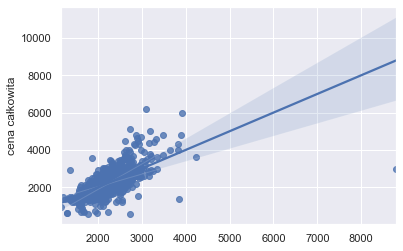

In [68]:
sns.regplot(x=prediction, y=y)

Model bez uwzględniania opisów radzi sobie całkiem dobrze, jednak pojawiają się punkty które znacząco odbiegają od predykcji. Być może metody pzetwarzania języka naturalnego będą potrafiły znaleźć pewne zależności i porpawić predyjkcję

In [69]:
df_waw_text['predykcja'] = lm.predict(X)
df_waw_text['predykcja'] = round(df_waw_text['predykcja'],2)

df_waw_text[df_waw_text['predykcja'] == df_waw_text['predykcja'].max()]

,dzielnica,od,poziom,zabudowa,powierzchnia,tytuł,opis,cena całkowita,predykcja
5,Wola,Biuro / Deweloper,1,Blok,400,2 pokoje z miejscem postojowym w Centrum przy ...,Na wynajem mieszkanie 2 pokoje w stanie idealn...,3000,8793.63


In [70]:
print(df_waw_text['opis'][df_waw_text['predykcja'] == df_waw_text['predykcja'].max()].to_markdown())

|    | opis                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
|---:|:------------------------------------------------------------------------------------------------------------------------

Jedna z predykcji jest wyjątkowo odległa od prawdy. Jest to jednak spowodowane błędem w ogłoszeniu. Z opisu wynika, że mieszkanie ma 40 metrów kwadratowych, natomiast w tabelce jest podane 400. 

<AxesSubplot:ylabel='cena całkowita'>

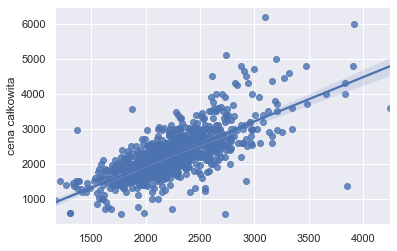

In [71]:
sns.regplot(x=np.delete(prediction, 5), y=y.drop(5))

Wykres regresji bez tej wartości wygląda znacznie lepiej. Jednak wciąż pojawiają się punkty które znacząco odbiegają od predykcji. Być może metody pzetwarzania języka naturalnego będą potrafiły znaleźć pewne zależności i porpawić predyjkcję. Usunę ją recznie, aby nie zaburzało mi to następnych wykresów.

In [72]:
drop_value(df_waw_text, 'predykcja', df_waw_text['predykcja'].max())

### EDA (Exploratory data analysis) pod kątem NLP

Tworzę kolumnę składniki resztowe oraz kolumnę ze znormalizowanymi składnikami resztowymi.

In [106]:
df_waw_text['składniki resztowe'] = df_waw_text['cena całkowita'] - df_waw_text['predykcja']
df_waw_text['składniki resztowe norm'] = (df_waw_text['predykcja'] - df_waw_text['cena całkowita'])/ df_waw_text['predykcja']
df_waw_text.head()

,dzielnica,od,poziom,zabudowa,powierzchnia,tytuł,opis,cena całkowita,predykcja,składniki resztowe,tytuł długość,opis długość,składniki resztowe norm
0,Białołęka,Osoby prywatnej,1,Blok,46,Mieszkanie 49 m2 1300 zł + czynsz. Od zaraz,Do wynajęcia mieszkanie 49m2 na Białołęce przy...,1800,2101.59,-301.59,9,35,0.143506
1,Ursynów,Osoby prywatnej,3,Blok,64,Wynajmę 3-pokojowe mieszkanie na Kabatach przy...,Wynajmę na co najmniej rok 3-pokojowe umeblowa...,3000,2591.80,408.20,7,228,-0.157497
2,Mokotów,Osoby prywatnej,8,Blok,85,Mieszkanie do wynajęcia Służew Bezpośrednio,Wynajmę bezpośrednio duże przestronne 85m2 mie...,2901,3135.60,-234.60,5,66,0.074818
3,Ursynów,Osoby prywatnej,3,Blok,45,Wynajem mieszkanie Warszawa na Ursynowie,Witam \nWynajmę śliczne mieszkanie na Ursynowi...,2800,2235.95,564.05,5,79,-0.252264
4,Białołęka,Osoby prywatnej,Parter,Blok,29,Funkcjonalna kawalerka z miejscem parkingowym ...,Nowa kawalerka z miejscem parkingowym w cenie ...,1750,1706.18,43.82,7,79,-0.025683


In [74]:
df_waw_group = df_waw_text.groupby('dzielnica')

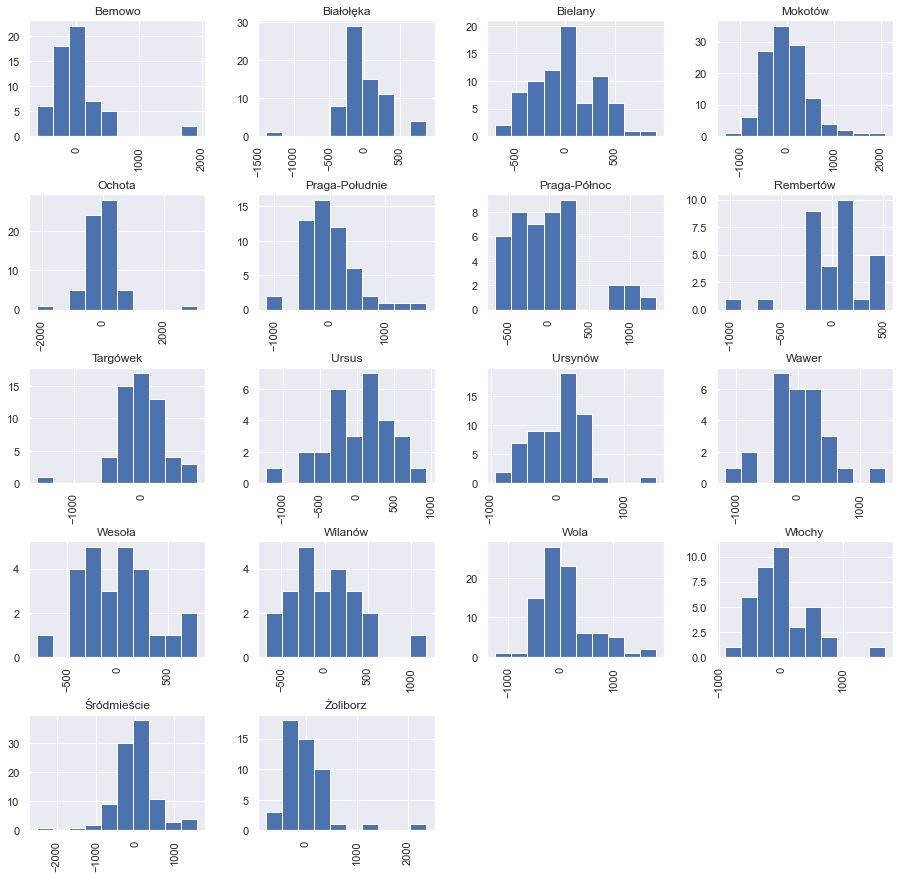

In [75]:
df_waw_text.hist(column='składniki resztowe', by='dzielnica', figsize=(15,15))
plt.show()

In [76]:
print(df_waw_text.median())
df_waw_group.median()

powierzchnia            40.00
cena całkowita        2195.00
predykcja             2195.24
składniki resztowe     -19.54
dtype: float64


,powierzchnia,cena całkowita,predykcja,składniki resztowe
dzielnica,,,,
Bemowo,45.5,2178.5,2247.835,-60.115
Białołęka,46.0,2001.0,2095.015,-67.535
Bielany,40.0,2101.0,2132.290,4.560
Mokotów,40.0,2200.0,2231.595,-42.535
Ochota,37.0,2101.0,2134.045,-13.470
Praga-Południe,47.5,2300.5,2309.120,-46.820
Praga-Północ,44.0,2301.0,2307.460,-14.160
Rembertów,38.0,1801.0,1778.140,70.060
Targówek,41.0,2001.0,2024.430,13.110


Mediana składników resztowych pokazuje, czy w danej dzielnicy większość cen jes zawyżonych (reszty dodatnie), czy zaniżonych (reszty ujemne).  *mediana dla Bemowa = -60.115, czyli 50% wszystkich predykcji jest niższa od ceny faktycznej o 60,12 zł*. Potwierdzenie togo widzać na wykresie powyżej.  
Z danych wynika, że model zawyża najbardziej ceny na Ursusie, Rembertowie i Ursynowie. Zaniża zaś na Żoliborzu, Bemowie i Białołęce. Najtrafniej ocenia mieszkania z Wawra, Wesołej, Śródmieścia i Bielan.  
Średnio dla całej Warszawy, większość predykcji jest nieznacznie zaniżona.

In [77]:
df_waw_group_abs = df_waw_group['składniki resztowe'].apply(abs)
df_waw_group_abs = pd.concat([df_waw_text.drop(['składniki resztowe'], axis=1), df_waw_group_abs], axis=1)

In [78]:
df_waw_group_abs.describe()

,powierzchnia,cena całkowita,predykcja,składniki resztowe
count,1011.000000,1011.000000,1011.000000,1011.000000
mean,42.828882,2235.282888,2229.552295,323.032532
std,15.855580,655.671979,377.197229,328.482567
min,2.000000,551.000000,1170.830000,1.320000
25%,32.000000,1801.000000,1999.780000,112.305000
50%,40.000000,2195.000000,2195.240000,238.520000
75%,50.000000,2550.000000,2428.700000,411.015000
max,160.000000,6200.000000,4248.120000,3105.310000


W tabeli powyżej przekształciłem kolumnę składnik resztowe w wartości absolutne (bez minusów). Dzięki temu mogę wyciągnąć średnią, która wynosi ok. 323,03. Model średnio mysli się taką wartość (bez uzględnienia w którą stronę). 

In [79]:
df_waw_text['tytuł długość'] = df_waw_text['tytuł'].str.split().apply(len)
df_waw_text['opis długość'] = df_waw_text['opis'].str.split().apply(len)

Liczę ilość słów w kolumnach tytuł i opis

In [80]:
df_waw_text.head()

,dzielnica,od,poziom,zabudowa,powierzchnia,tytuł,opis,cena całkowita,predykcja,składniki resztowe,tytuł długość,opis długość
0,Białołęka,Osoby prywatnej,1,Blok,46,Mieszkanie 49 m2 1300 zł + czynsz. Od zaraz,Do wynajęcia mieszkanie 49m2 na Białołęce przy...,1800,2101.59,-301.59,9,35
1,Ursynów,Osoby prywatnej,3,Blok,64,Wynajmę 3-pokojowe mieszkanie na Kabatach przy...,Wynajmę na co najmniej rok 3-pokojowe umeblowa...,3000,2591.80,408.20,7,228
2,Mokotów,Osoby prywatnej,8,Blok,85,Mieszkanie do wynajęcia Służew Bezpośrednio,Wynajmę bezpośrednio duże przestronne 85m2 mie...,2901,3135.60,-234.60,5,66
3,Ursynów,Osoby prywatnej,3,Blok,45,Wynajem mieszkanie Warszawa na Ursynowie,Witam \nWynajmę śliczne mieszkanie na Ursynowi...,2800,2235.95,564.05,5,79
4,Białołęka,Osoby prywatnej,Parter,Blok,29,Funkcjonalna kawalerka z miejscem parkingowym ...,Nowa kawalerka z miejscem parkingowym w cenie ...,1750,1706.18,43.82,7,79


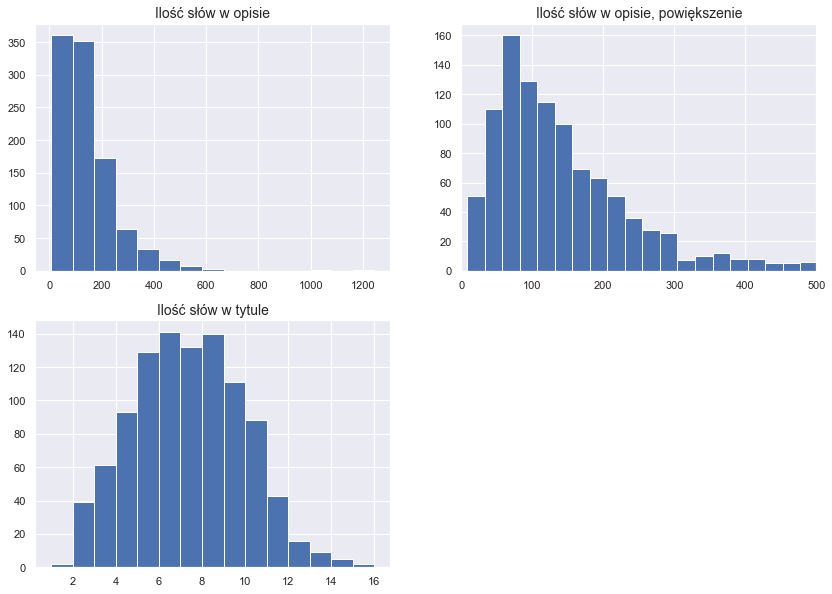

In [81]:
plt.figure(figsize=(14,10))

plt.subplot(2, 2, 3)
plt.hist(df_waw_text['tytuł długość'], bins=15)
plt.title('Ilość słów w tytule', fontdict={'fontsize':14})

plt.subplot(2, 2, 1)
plt.hist(df_waw_text['opis długość'], bins=15)
plt.title('Ilość słów w opisie', fontdict={'fontsize':14})

plt.subplot(2, 2, 2)
plt.hist(df_waw_text['opis długość'], bins=50)
plt.title('Ilość słów w opisie, powiększenie', fontdict={'fontsize':14})
plt.xlim(0, 500)
plt.show()

Większość opisów ogłoszeń liczy od 25 do 125 słów. Istnieje pare bardzo długich (ponad 600 słów). Większość tytułów posiada od 4 do 11 słów. Nie występują watrości zacząco odbiegające od średniej

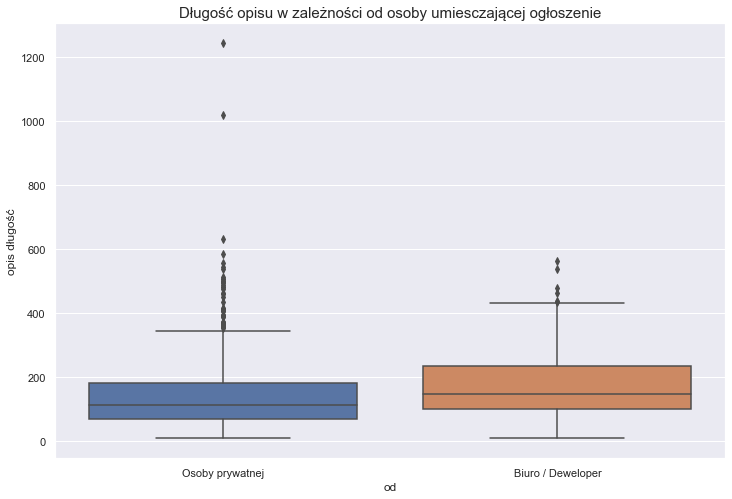

In [82]:
plt.figure(figsize=(12,8))
sns.boxplot(x=df_waw_text['od'], y=df_waw_text['opis długość'])
plt.title('Długość opisu w zależności od osoby umiesczającej ogłoszenie', fontdict={'fontsize':15})
plt.show()

Ogłoszenia od osób prywatnych są zazwyczaj krótsze, jednak często pojawiają się ogłoszenia o wiele dłuższe. Ogłoszenia od deweloperów są bardziej usystematyzowane. 

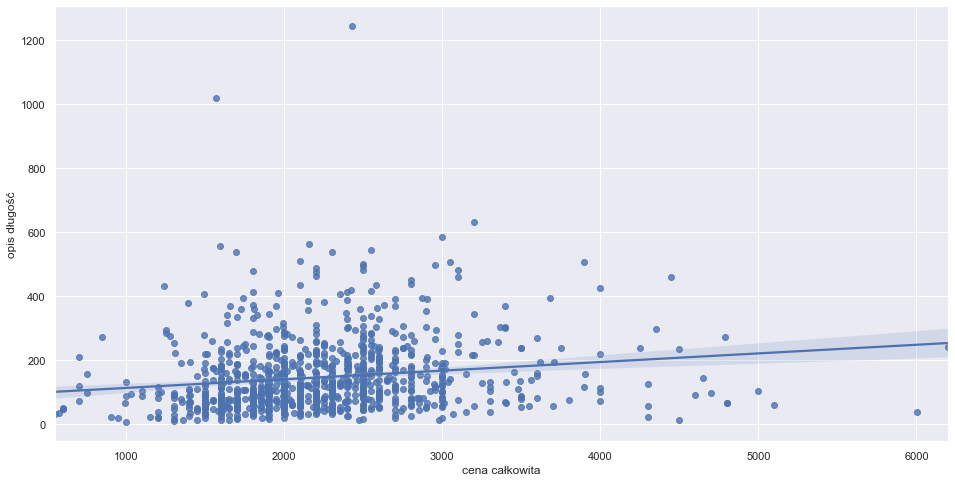

In [83]:
plt.figure(figsize=(16,8))
sns.regplot(x=df_waw_text['cena całkowita'], y=df_waw_text['opis długość'])
plt.show()

Liniowa zależność między długością opisu a ceną mieszkania nie występuje.

Zapiszę posiadaną tabelę za pomocą pickle

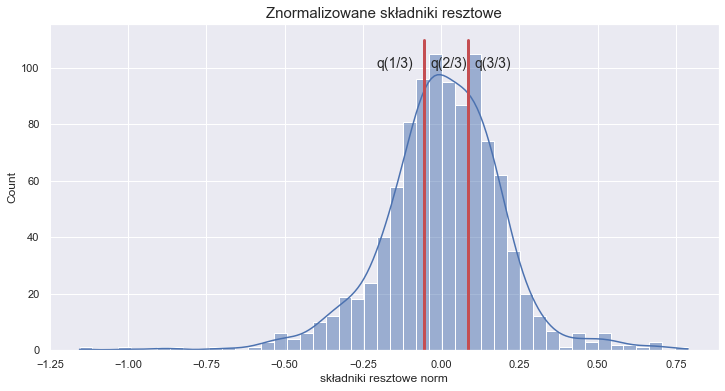

In [180]:
q1 = df_waw_text['składniki resztowe norm'].quantile(q=1/3)
q2 = df_waw_text['składniki resztowe norm'].quantile(q=2/3)

plt.figure(figsize=(12,6))
sns.histplot(df_waw_text['składniki resztowe norm'], kde = True)
plt.title('Znormalizowane składniki resztowe', fontdict={'fontsize':15})

plt.plot([q1,q1], [0,110], color='r', lw=3)
plt.plot([q2,q2], [0,110], color='r', lw=3)
plt.text(q1-0.15, 100, 'q(1/3)', fontdict={'fontsize':14})
plt.text(q1+0.02, 100, 'q(2/3)', fontdict={'fontsize':14})
plt.text(q2+0.02, 100, 'q(3/3)', fontdict={'fontsize':14})

plt.show()

Znormalizowane składniki resztowe będą dla mnie stanowiły grupy odniesienia w dalszej części. *q(1/3)* jest grupą niedowardościowaną (jedna trzecia wszystkich obserwacji). *q(2/3)* jest grupą trafnie oceniną (jedna trzecia wszystkich obserwacji), a *q(3/3)* jest grupą przecenioną (jedna trzecia wszystkich obserwacji). Na podstawie opisów spróbuję przypisać właściwe etykiety do ogłoszeń.

In [91]:
df_waw_text.to_pickle(r'E:\python\projects\apartments\pickle\df_waw_text.pickle')

## Przetwarzanie tekstu

In [85]:
import re

from sklearn.feature_extraction.text import CountVectorizer

In [93]:
df_waw_text = pd.read_pickle(r'E:\python\projects\apartments\pickle\df_waw_text.pickle')

### Czyszczenie tekstu

In [86]:
df_waw_group_abs.sort_values('składniki resztowe', ascending=False).head(10)

,dzielnica,od,poziom,zabudowa,powierzchnia,tytuł,opis,cena całkowita,predykcja,składniki resztowe
396,Ochota,Osoby prywatnej,1,Apartamentowiec,70,Mieszkanie luksusowe w centrum,Nowoczesny apartament przy ul. Koszykowej\nROZ...,6200,3094.69,3105.31
246,Śródmieście,Osoby prywatnej,4,Apartamentowiec,107,Od Nowego Roku zamieszkaj ładniej w stylowym a...,Fajny pokój w artystycznym apartamencie na Pow...,1350,3855.26,2505.26
737,Żoliborz,Biuro / Deweloper,3,Apartamentowiec,57,"Apartament Warszawa Gen. Zajączka - 57m2, base...",Przepiękny apartament zlokalizowany w dobrze s...,5100,2739.36,2360.64
320,Ochota,Osoby prywatnej,3,Apartamentowiec,53,Mieszkanie 53 mkw do wynajecia Centrum Warszaw...,"piękne, nowe mieszkanie w super punkcie Warsza...",575,2729.27,2154.27
330,Mokotów,Osoby prywatnej,4,Kamienica,130,Mieszkanie do wynajęcia,Wyjątkowe mieszkanie do wynajęcia w okolicach ...,6001,3916.48,2084.52
515,Bemowo,Osoby prywatnej,7,Blok,77,Wynajmę bezpośrednio 4 pokoje Bemowo,Piękne 4 pokojowe mieszkanie każdy pokój z nie...,4801,2873.82,1927.18
811,Bemowo,Osoby prywatnej,1,Blok,65,Wynajmę mieszkanie 65m2 Pruszków dla firmy,"Wynajmę firmie mieszkanie do 9 osób , umeblowa...",4500,2615.20,1884.80
176,Wola,Osoby prywatnej,9,Apartamentowiec,72,Wola mieszkanie 72m2- 5 min od metra ( niedale...,Witam wynajmę mieszkanie na woli ul Karolkowa ...,5000,3195.34,1804.66
676,Praga-Południe,Osoby prywatnej,2,Apartamentowiec,61,"Mieszkanie 61 m, nowym budynku przy Międzynaro...","Oferujemy wyposażone, trzypokojowe, klimatyzow...",4650,2902.03,1747.97
137,Wola,Osoby prywatnej,1,Apartamentowiec,65,Wynajme mieszkanie,Mam nowe mieszkanie na ul Grzybowska 85. Powie...,4700,2992.79,1707.21


In [21]:
for i in range(20):
    print(df_waw_group_abs.sort_values('składniki resztowe', ascending=False).iloc[i]['opis'], '\n')

Nowoczesny apartament przy ul. Koszykowej
ROZKŁAD:
Lokal składa się z salonu, połączonego z aneksem kuchennym, garderoby, łazienki, pomieszczenia gospodarczego, dwóch sypialni i jest wykończony z dbałością o każdy detal, wysoki standard wykończenia. 
STANDARD:
Bardzo eleganckie klatki schodowe, marmurowe posadzki i schody, winda i recepcja dopełniają poczucie komfortu i elegancji. Na podłodze dębowe deski, zabudowy i kuchnia zrobione na wymiar, włoskie kafle w łazienkach, armatura oraz sprzęt AGD w najwyższej półki.
LOKALIZACJA:
Ten luksusowy apartament znakduje się na tyłach pl. Konstytucji, zaraz przy Hali Koszyki w kameralnej i prestiżowej inwestycji z 2018 roku, która łączy ze sobą wyremontowaną neorenesansową kamienicę oraz modernistyczną część nowego budynku.
INFORMACJE DODATKOWE:
Budynek znajduję się na dziedzińcu, dzięki czemu w mieszkaniu panuje idealna cisza.
Istnieje mozliwosc wynajęcia miejsca garażowego w podziemiu.

LAYOUT:
The property consists of a living room with a ki

In [22]:
def clean_data(text):
    text = text.lower() # małe litery
    text = re.sub(r'\W', ' ', text) # usunięcie znaków np. nawiasy
    text = re.sub('\n', ' ', text) # usuniecie nowych linii
    return text
    #text = re.sub('\w*\d\w*', '', text)

In [32]:
description = df_waw_text['opis'].apply(clean_data)
title = df_waw_text['tytuł'].apply(clean_data)
data_clean = pd.concat([df_waw_text['cena całkowita'], description, title], axis=1)
data_clean.head()

,cena całkowita,opis,tytuł
0,1800,do wynajęcia mieszkanie 49m2 na białołęce przy...,mieszkanie 49 m2 1300 zł czynsz od zaraz
1,3000,wynajmę na co najmniej rok 3 pokojowe umeblowa...,wynajmę 3 pokojowe mieszkanie na kabatach przy...
2,2901,wynajmę bezpośrednio duże przestronne 85m2 mie...,mieszkanie do wynajęcia służew bezpośrednio
3,2800,witam wynajmę śliczne mieszkanie na ursynowie...,wynajem mieszkanie warszawa na ursynowie
4,1750,nowa kawalerka z miejscem parkingowym w cenie ...,funkcjonalna kawalerka z miejscem parkingowym ...


### Wektoryzacja słów

In [97]:
pol_stop_words = 'ach aj albo bardzo bez bo być ci cię ciebie co czy daleko dla dlaczego dlatego do dobrze dokąd dość dużo dwa dwaj dwie dwoje dziś dzisiaj gdyby gdzie go ich ile im inny ja ją jak jakby jaki je jeden jedna jedno jego jej jemu jeśli jest jestem jeżeli	już każdy kiedy kierunku kto ku lub ma mają mam mi mną mnie moi mój moja moje może mu my na nam nami nas nasi nasz nasza nasze natychmiast nią nic nich nie niego niej niemu nigdy nim nimi niż obok od około on ona one oni ono owszem po	pod ponieważ przed przedtem są sam sama się skąd tak taki tam ten to tobą tobie tu tutaj twoi twój twoja twoje ty wam wami was wasi wasz wasza wasze we więc wszystko wtedy wy żaden zawsze że'.split()
count_vectorizer = CountVectorizer(stop_words=pol_stop_words, lowercase=False)
sparse_matrix_description = count_vectorizer.fit_transform(data_clean['opis'])
sparse_matrix_title = count_vectorizer.fit_transform(data_clean['tytuł'])

In [101]:
print(sparse_matrix_description.shape, sparse_matrix_title.shape)

(1011, 13524) (1011, 1342)
